### Results on ImageNet1k and ImageNetV2

In [3]:
from pytorch_lightning import utilities as pl_utils
from pytorch_lightning.trainer.trainer import Trainer
from pytorch_lightning.plugins import DDPPlugin
import torch
import pathlib
from functools import partial
import sys, glob, os, copy
import numpy as np

sys.path.append('..')
sys.path.append('../deep-learning-base')
sys.path.append('../deep-learning-base/training')
sys.path.append('../deep-learning-base/datasets')
sys.path.append('../partially_inverted_reps')

import plot_helper as plt_hp
import output as out
from training import LitProgressBar, NicerModelCheckpointing
import training.finetuning as ft
import architectures as arch
from architectures.callbacks import LightningWrapper, LinearEvalWrapper
from attack.callbacks import AdvCallback
from data_modules import DATA_MODULES
import dataset_metadata as dsmd
from partial_loss import PartialInversionLoss, PartialInversionRegularizedLoss
from __init__ import DATA_PATH_IMAGENET, DATA_PATH, SERVER_PROJECT_PATH

/NS/twitter_archive2/work/vnanda/minconda3/envs/dl_base/lib/python3.7/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [4]:
DATA_TO_PATH = {
    'imagenetv2':'/NS/robustness_2/work/vnanda/data',
    'places365': '/NS/robustness_4/work/vnanda/data',
    'imagenet': DATA_PATH_IMAGENET}

In [5]:
CHECKPOINT_PATHS = {
    'resnet50': {
        'nonrob': '',
        'robustl2eps3': '/NS/robustness_3/work/vnanda/adv-robustness/logs/'\
                        'robust_imagenet/eps3/resnet-50-l2-eps3.ckpt'}
}

In [6]:
SEED = 2
NUM_NODES = 1
DEVICES = 1
BASE_DIR = f"{pathlib.Path('.').parent.resolve()}/checkpoints"

FINETUNE_BS = 512
EVAL_BATCH_SIZE = 100
SAMPLE_MODE = 'random'

In [7]:
def save_predictions(model_path, output):
    preds_path = f'{model_path.split(".ckpt")[0]}.pred'
    dirs = preds_path.split('/')[:-1]
    for i in range(2,len(dirs)+1):
        out.create_dir('/'.join(dirs[:i]))
    torch.save({'pred': output[0].detach().cpu(), 'gt': output[2].detach().cpu()}, preds_path)

def load_predictions(model_path):
    preds_path = f'{model_path.split(".ckpt")[0]}.pred'
    if os.path.exists(preds_path):
        return torch.load(preds_path)

def accuracy(gt, pred):
    pred = torch.argmax(pred, 1)
    return torch.sum(gt == pred) / len(gt)


def get_test_acc(model, source_dataset, finetuning_dataset, checkpoint_path, model_path,
                 seed, fraction, pred_save_path=None, full_layer_acc=False):
    dm = DATA_MODULES[finetuning_dataset](
        data_dir=DATA_TO_PATH[finetuning_dataset],
        transform_train=dsmd.TRAIN_TRANSFORMS_TRANSFER_DEFAULT(224),
        transform_test=dsmd.TEST_TRANSFORMS_DEFAULT(224),
        batch_size=EVAL_BATCH_SIZE)
    dm.init_remaining_attrs(source_dataset)

    ## assign mean and std from source dataset
    m1 = arch.create_model(model, source_dataset, pretrained=True,
                           checkpoint_path=checkpoint_path, seed=SEED, 
                           num_classes=dsmd.DATASET_PARAMS[source_dataset]['num_classes'],
                           callback=partial(LightningWrapper, 
                                            dataset_name=source_dataset,
                                            inference_kwargs={'with_latent': True}),
                           loading_function_kwargs={'strict': False})
    if not full_layer_acc:
        state_dict = torch.load(model_path)
        new_layer = ft.setup_model_for_finetuning(
            m1.model, 
            dsmd.DATASET_PARAMS[finetuning_dataset]['num_classes'],
            SAMPLE_MODE, fraction, seed)

        linear_layer = list(m1.model.named_modules())[-1][1]
        linear_layer.load_state_dict({k.split('.')[-1]:v \
                                      for k,v in state_dict['state_dict'].items()}, strict=True)
        if hasattr(new_layer, 'neuron_indices') and 'neuron_indices' in state_dict:
            assert torch.all(new_layer.neuron_indices == state_dict['neuron_indices'])

    pl_utils.seed.seed_everything(seed, workers=True)

    trainer = Trainer(accelerator='gpu', 
                      devices=DEVICES,
                      num_nodes=NUM_NODES,
                      log_every_n_steps=1,
                      auto_select_gpus=True, 
                      deterministic=True,
                      check_val_every_n_epoch=1,
                      num_sanity_val_steps=0,
                      callbacks=[
                        LitProgressBar(['loss', 
                                        'running_test_acc'])])

    output = trainer.predict(m1, dataloaders=[dm.test_dataloader()])
    save_predictions(model_path if pred_save_path is None else pred_save_path, output)
    gt, pred = output[2], output[0]
    return accuracy(gt, pred)

In [30]:
def results(model, source_dataset, shift_dataset=None, hard_dataset=None, 
            FRACTIONS_OR_NUMBERS=None, finetune_bs=None):
    assert (shift_dataset is not None) ^ (hard_dataset is not None), \
        'Only one of shift_dataset or hard_dataset can be specified'
    ft_dataset = source_dataset if hard_dataset is None else hard_dataset
    finetune_bs = FINETUNE_BS if finetune_bs is None else finetune_bs
    
    plt_str = '== Dataset shift results ==\n\n'
    append_to_res = {}
    for append in CHECKPOINT_PATHS[model].keys():
        ds_to_frac_wise_test = {}
        plt_str += f'=== {model} - {append} ===\n\n'
        frac_wise_test_accs_og, frac_wise_test_accs_shifted = {}, {}
        if FRACTIONS_OR_NUMBERS is None:
            FRACTIONS_OR_NUMBERS = sorted(
                list(set(
                    [float(x.split('/frac-')[1].split('-')[0]) for x in \
                        glob.glob(f'./checkpoints/{model}-base-'
                              f'{source_dataset}-ft-{ft_dataset}/'
                              f'*-mode-{SAMPLE_MODE}-*-bs-*-{append}') \
                     if len(x.split('/frac-')[1].split('-')[0]) == 7 and \
                        'full-feature' not in x and \
                        'layer' not in x and \
                        'pool' not in x]
                    )))
        for frac in FRACTIONS_OR_NUMBERS:
            if isinstance(frac, int):
                actual_fraction = frac / FRACTIONS_OR_NUMBERS[-1]
            else:
                actual_fraction = frac
            PARTIAL_CHOICE_SEEDS = sorted(
                list(set(
                    [int(x.split('-seed-')[1].split('-')[0]) for x in \
                        glob.glob(f'./checkpoints/{model}-base-'
                                  f'{source_dataset}-ft-{ft_dataset}/'
                                  f'frac-{actual_fraction:.5f}-mode-{SAMPLE_MODE}-*-bs-*-{append}') \
                    if len(x.split('/frac-')[1].split('-')[0]) == 7 and \
                       'full-feature' not in x and \
                       'layer' not in x and \
                       'pool' not in x]
                    )))
            for seed in PARTIAL_CHOICE_SEEDS:
                model_path = [x for x in glob.glob(f'{BASE_DIR}/'
                                       f'{model}-base-{source_dataset}-ft-{ft_dataset}/'
                                       f'frac-{actual_fraction:.5f}-mode-{SAMPLE_MODE}-seed-{seed}-'
                                       f'ftmode-linear-lr-*-bs*-{append}/'
                                       '*-topk=1.ckpt') \
                              if len(x.split('/frac-')[1].split('-')[0]) == 7 and \
                                 'full-feature' not in x and \
                                 'layer' not in x and \
                                 'pool' not in x]
                if len(model_path) == 0:
                    continue
                model_path = model_path[0]
                
                pickled_preds_og = load_predictions(model_path)
                if pickled_preds_og is not None:
                    test_acc_og = accuracy(pickled_preds_og['gt'], pickled_preds_og['pred']).item()
                else:
                    test_acc_og = get_test_acc(model, source_dataset, ft_dataset, 
                                               CHECKPOINT_PATHS[model][append], 
                                               model_path, seed, actual_fraction)
                if shift_dataset:
                    fake_shift_model_path = model_path.replace(f'ft-{source_dataset}', f'ft-{shift_dataset}')
                    pickled_preds_shift = load_predictions(fake_shift_model_path)
                    if pickled_preds_shift is not None:
                        test_acc_shift = accuracy(pickled_preds_shift['gt'], pickled_preds_shift['pred']).item()
                    else:
                        test_acc_shift = get_test_acc(model, source_dataset, shift_dataset, 
                                                      CHECKPOINT_PATHS[model][append], 
                                                      model_path, seed, actual_fraction, 
                                                      pred_save_path=fake_shift_model_path)

                if frac in frac_wise_test_accs_shifted:
                    frac_wise_test_accs_og[frac].append(test_acc_og)
                    if shift_dataset:
                        frac_wise_test_accs_shifted[frac].append(test_acc_shift)
                else:
                    frac_wise_test_accs_og[frac] = [test_acc_og]
                    if shift_dataset:
                        frac_wise_test_accs_shifted[frac] = [test_acc_shift]                


        if shift_dataset is not None:
            full_model_path = f'{BASE_DIR}/{model}-base-{source_dataset}-ft-{ft_dataset}/'\
                          f'frac-1.00000-mode-{SAMPLE_MODE}-seed-1-ftmode-linear-lr-0.1-'\
                          f'bs-{finetune_bs}-{append}/full_layer_preds.ckpt'
            pickled_preds_og = load_predictions(full_model_path)
            if pickled_preds_og is not None:
                frac_wise_test_accs_og[1.] = \
                    [accuracy(pickled_preds_og['gt'], pickled_preds_og['pred']).item()]
            else:
                frac_wise_test_accs_og[1.] = \
                    get_test_acc(model, source_dataset, ft_dataset, 
                                 CHECKPOINT_PATHS[model][append], 
                                 full_model_path, seed, 1., 
                                 full_layer_acc=True)
            full_model_path_shift = full_model_path.replace(f'ft-{source_dataset}', f'ft-{shift_dataset}')
            pickled_preds_shift = load_predictions(full_model_path_shift)
            if pickled_preds_shift is not None:
                frac_wise_test_accs_shifted[1.] = \
                    [accuracy(pickled_preds_shift['gt'], pickled_preds_shift['pred']).item()]
            else:
                frac_wise_test_accs_shifted[1.] = \
                    get_test_acc(model, source_dataset, shift_dataset, 
                                 CHECKPOINT_PATHS[model][append], 
                                 model_path, seed, 1., 
                                 pred_save_path=full_model_path_shift, full_layer_acc=True)


        legend_vals = [source_dataset, shift_dataset] if shift_dataset is not None else [ft_dataset]
        y_values_for_plotting = [
            [np.nanmean(x_val) for x_val in list(
                zip(*sorted(frac_wise_test_accs_og.items(), key=lambda x:x[0])))[1]], 
            [np.nanmean(x_val) for x_val in list(
                zip(*sorted(frac_wise_test_accs_shifted.items(), key=lambda x:x[0])))[1]]] \
            if shift_dataset is not None else \
                [[np.nanmean(x_val) for x_val in list(
                    zip(*sorted(frac_wise_test_accs_og.items(), key=lambda x:x[0])))[1]]]
        y_errs_for_plotting = [
            [np.nanstd(x_val) for x_val in list(
                zip(*sorted(frac_wise_test_accs_og.items(), key=lambda x:x[0])))[1]], 
            [np.nanstd(x_val) for x_val in list(
                zip(*sorted(frac_wise_test_accs_shifted.items(), key=lambda x:x[0])))[1]]] \
            if shift_dataset is not None else \
                [[np.nanstd(x_val) for x_val in list(
                    zip(*sorted(frac_wise_test_accs_og.items(), key=lambda x:x[0])))[1]]]
        x_vals_for_plotting = [
            list(zip(*sorted(frac_wise_test_accs_og.items(), key=lambda x:x[0])))[0], 
            list(zip(*sorted(frac_wise_test_accs_shifted.items(), key=lambda x:x[0])))[0]] \
            if shift_dataset is not None else \
                [list(zip(*sorted(frac_wise_test_accs_og.items(), key=lambda x:x[0])))[0]]
        
        if shift_dataset is not None:
            append_to_res[f'{append}-{source_dataset}'] = frac_wise_test_accs_og
            append_to_res[f'{append}-{shift_dataset}'] = frac_wise_test_accs_shifted
        else:
            append_to_res[f'{append}-{ft_dataset}'] = frac_wise_test_accs_og
        
        plt_str += '{}\n\n'.format(plt_hp.get_wiki_link(plt_hp.line_plot(
            y_values_for_plotting, 
            'Fraction of Neurons', 'Accuracy', 
            shift_dataset if shift_dataset is not None else hard_dataset, 
            subfolder=source_dataset, 
            filename=f'{model}_{append}_bs_{finetune_bs}_shift_'\
                     f'{shift_dataset if shift_dataset is not None else hard_dataset}', 
            extension='png', 
            x_vals=x_vals_for_plotting, 
            legend_vals=legend_vals, linestyles=['-', '-'], y_lims=(0.,1.), root_dir='.', 
            paper_friendly_plots=True, plot_inside=False, legend_location='best', 
            savefig=True, figsize=(10,6), marker=[True] * len(legend_vals), 
            results_subfolder_name='imagenet_shifts_or_harder_ds', grid_spacing=None, 
            y_err=y_errs_for_plotting, 
            legend_ncol=None), SERVER_PROJECT_PATH, size=700))
    
    with open(f'./results/imagenet_shifts_or_harder_ds/{source_dataset}/'
              f'wiki_results-{model}-{shift_dataset if shift_dataset is not None else hard_dataset}.txt', 
              'w') as fp:
        fp.write(plt_str)
    out.upload_results(['{}/{}/{}'.format(plt_hp.RESULTS_FOLDER_NAME, 'imagenet_shifts', source_dataset)], 
        'results', SERVER_PROJECT_PATH, '.png')
    return append_to_res

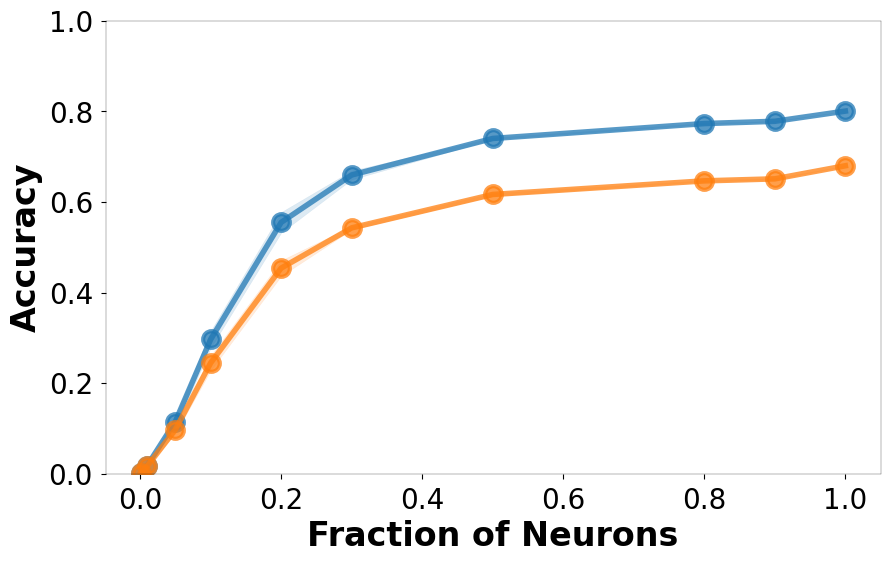

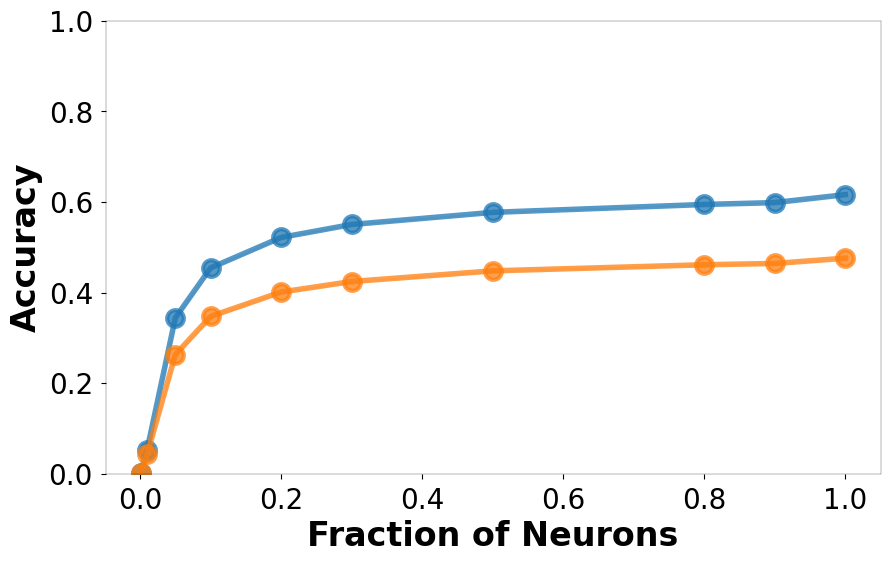

Uploading results in ['results/imagenet_shifts/imagenet'] to contact.mpi-sws.org...
Uploading 0 files to server


In [31]:
results_imagenetv2 = results('resnet50', 'imagenet', shift_dataset='imagenetv2')

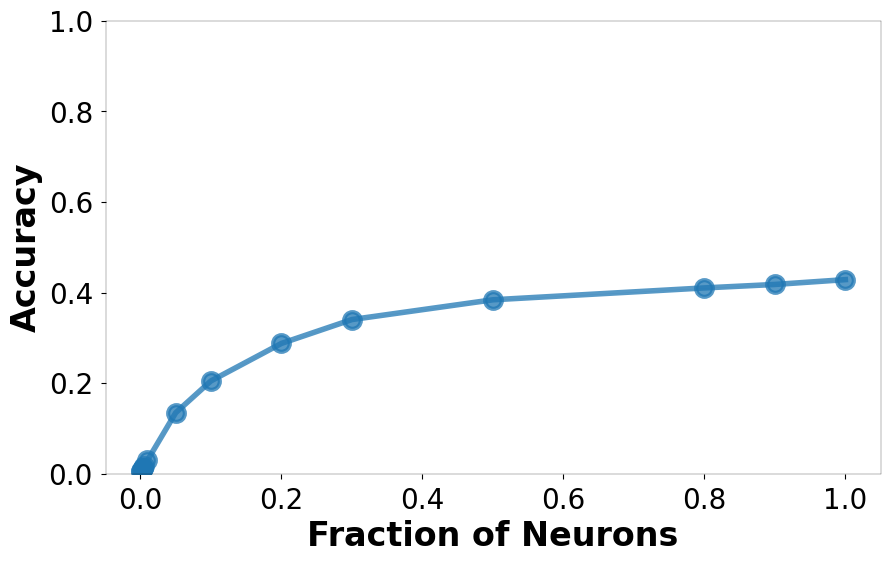

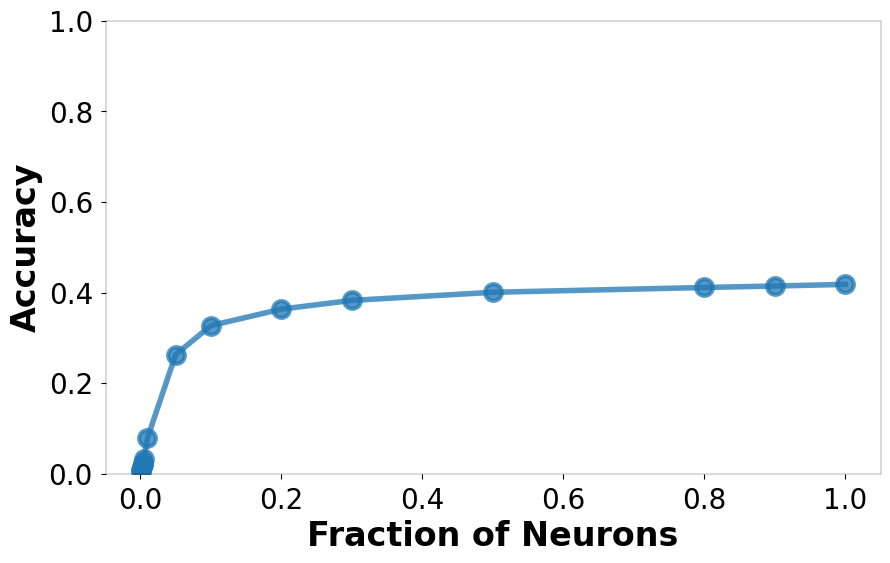

Uploading results in ['results/imagenet_shifts/imagenet'] to contact.mpi-sws.org...
Uploading 0 files to server


In [32]:
results_places365 = results('resnet50', 'imagenet', hard_dataset='places365', finetune_bs=1024)

In [36]:
all_res = {**results_imagenetv2, **results_places365}
all_res

{'nonrob-imagenet': {0.001: [0.002400000113993883,
   0.002199999988079071,
   0.00203999993391335,
   0.0017600000137463212,
   0.001979999942705035],
  0.01: [0.017960000783205032,
   0.019659999758005142,
   0.01916000060737133,
   0.016459999606013298,
   0.016599999740719795],
  0.05: [0.10958000272512436,
   0.1009799987077713,
   0.12015999853610992,
   0.11253999918699265,
   0.1334799975156784],
  0.1: [0.29308000206947327,
   0.27230000495910645,
   0.31352001428604126,
   0.32197999954223633,
   0.28161999583244324],
  0.2: [0.5281800031661987,
   0.5801399946212769,
   0.5567200183868408,
   0.5798799991607666,
   0.5301600098609924],
  0.3: [0.6498000025749207,
   0.6747400164604187,
   0.6595199704170227,
   0.6651600003242493,
   0.6488199830055237],
  0.5: [0.7380800247192383,
   0.7404800057411194,
   0.7432000041007996,
   0.7414399981498718,
   0.7380800247192383],
  0.8: [0.7728000283241272,
   0.7739400267601013,
   0.7725200057029724,
   0.7751200199127197,
   0.7

[0.002075999998487532, 0.01796800009906292, 0.11534799933433533, 0.2965000033378601, 0.5550160050392151, 0.659607994556427, 0.7402560114860535, 0.7731360197067261, 0.7781760096549988, 0.8006799817085266]
[0.00021481158161647796, 0.0012984053692269698, 0.010950057406994706, 0.01874919695784298, 0.02276105538200436, 0.00971996402390102, 0.001979339646487758, 0.001299688462592547, 0.0008736565702493325, 0.0]
(0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.8, 0.9, 1.0)


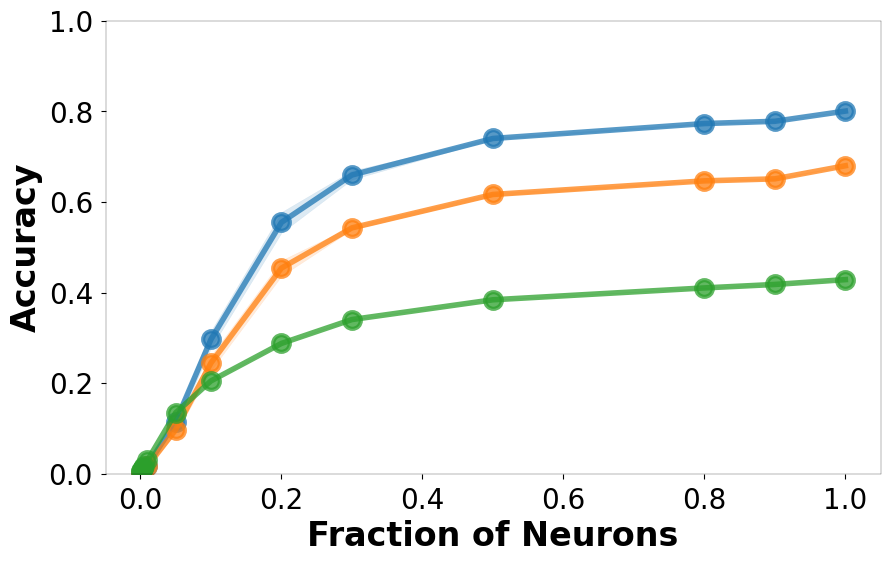

[0.002348000044003129, 0.053307998925447464, 0.34439200162887573, 0.45455600023269654, 0.521832001209259, 0.55038400888443, 0.5771080017089844, 0.5945400118827819, 0.5986879944801331, 0.6162599921226501]
[0.0002606453373603502, 0.0027578139884040665, 0.004446619213356119, 0.002586343609696498, 0.0017568465419296525, 0.0016329446825392353, 0.0014638760469739868, 0.00047781969469138904, 0.0005602255134135384, 0.0]
(0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.8, 0.9, 1.0)


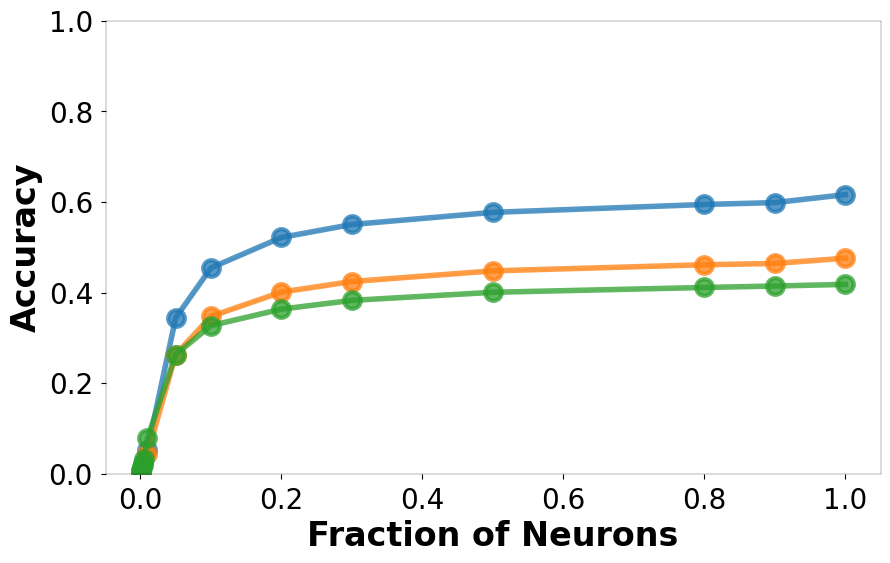

In [47]:
legend_vals = ['Imagenet', 'ImagenetV2', 'Places365']
appends = ['nonrob', 'robustl2eps3']
model = 'resnet50'
source_dataset = 'imagenet'
finetune_bs = 1024


for append in appends:
    res_slice = [all_res[f'{append}-{ftds.lower()}'] for ftds in legend_vals]
    y_values_for_plotting = [
        [np.nanmean(x_) for x_ in \
        list(zip(*sorted(res_.items(), key=lambda x:x[0])))[1]]
        for res_ in res_slice
    ]
    y_errs_for_plotting = [
        [np.nanstd(x_) for x_ in \
        list(zip(*sorted(res_.items(), key=lambda x:x[0])))[1]]
        for res_ in res_slice
    ]
    x_vals_for_plotting = [
        list(zip(*sorted(res_.items(), key=lambda x:x[0])))[0]
        for res_ in res_slice
    ]
    print (y_values_for_plotting[0])
    print (y_errs_for_plotting[0])
    print (x_vals_for_plotting[0])

    plt_hp.line_plot(
        y_values_for_plotting, 
        'Fraction of Neurons', 'Accuracy', 
        'ALL DS', 
        subfolder=source_dataset, 
        filename=f'{model}_{append}_bs_{finetune_bs}_shift_and_hard', 
        extension='png', 
        x_vals=x_vals_for_plotting, 
        legend_vals=legend_vals, linestyles=['-', '-', '-'], y_lims=(0.,1.), root_dir='.', 
        paper_friendly_plots=True, plot_inside=False, legend_location='best', 
        savefig=True, figsize=(10,6), marker=[True] * len(legend_vals), 
        results_subfolder_name='imagenet_shifts_or_harder_ds', grid_spacing=None, 
        y_err=y_errs_for_plotting, 
        legend_ncol=None)